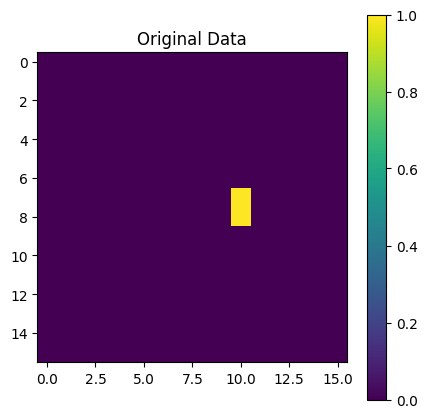

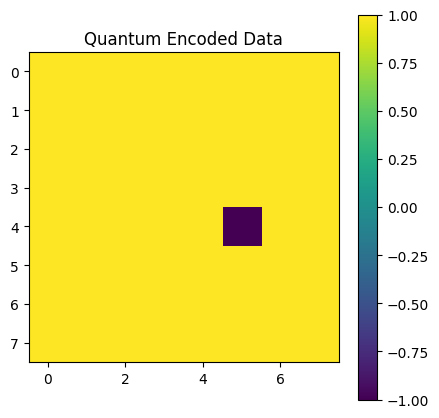

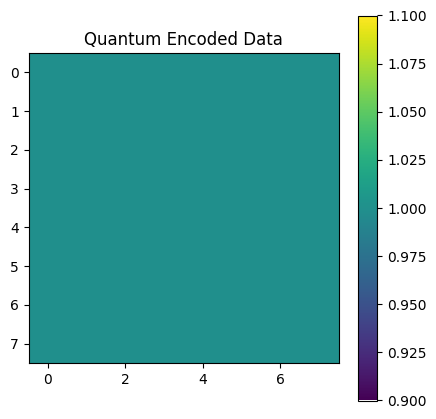

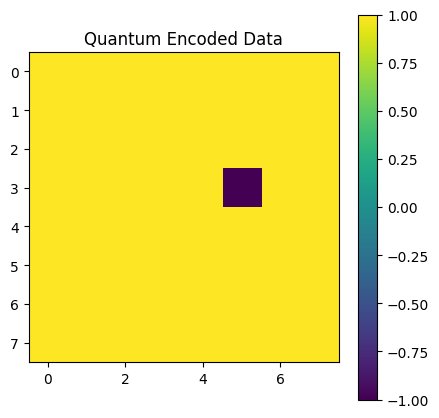

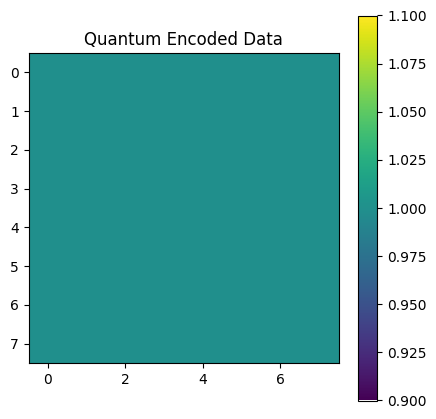

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib
import pennylane as qml
from pennylane.templates import RandomLayers

# filename="C:/Users/realc/OneDrive/Documents/GSOC/data/small_QG_train_normalized_5"
filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG_train_normalized_16_xl"

file = h5py.File(filename,"r")

# plt.imshow(np.mean(file['X'], axis=0), norm=matplotlib.colors.LogNorm())
# plt.colorbar()

data_X = np.array(file['X'])

num_qubits = 16
dev = qml.device("default.qubit", wires=num_qubits)
n_layers = 1
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def angle_circuit(phi):
    for j in range(4):
        qml.RX(np.pi * phi[j], wires=j)
    # RandomLayers(rand_params, wires=list(range(4)))
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def angle_encoding(data, sample=0):
    out = np.zeros((8, 8, 4))

    for i in range(0, 16, 2):
        for j in range(0, 16, 2):
            q_results = angle_circuit(
                [
                    data[sample, i, j],
                    data[sample, i, j+1],
                    data[sample, i+1, j],
                    data[sample, i+1, j+1]
                ]
            )
            for c in range(4):
                out[i//2, j//2, c] = q_results[c]
    return out

def visualize_data(original_data, encoded_data, sample_index=0):
    # original_mean = np.mean(original_data, axis=0)
    original_sample = original_data[sample_index]
    
    plot_figure(original_sample, title="Original Data")

    encoded_sample = encoded_data[sample_index]
    encoded_image = encoded_data
    for channel in range(4):
        encoded_image = encoded_sample[:, :, channel]

        plot_figure(encoded_image, title="Quantum Encoded Data")

def plot_figure(data, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(data, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()

encoded_data = []
num_samples = len(data_X)
num_samples = 100
for sample in range(num_samples):
    encoded_data.append(angle_encoding(data_X, sample))
encoded_data = np.array(encoded_data)

visualize_data(data_X, encoded_data, sample_index=0)


In [16]:
from scipy.stats import unitary_group

seed = 42

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

def haar_random_unitary(seed=None):
    if seed is not None:
        np.random.seed(seed)
    return unitary_group.rvs(8)

def scramble_state_vectors(encoded_data , seed):
    scrambled_vectors = []

    for i in range(num_samples):
        U = haar_random_unitary(seed)

        scrambled_state = np.dot(U, encoded_data[i])
        scrambled_state /= np.linalg.norm(scrambled_state)
        scrambled_vectors.append(scrambled_state)

        if seed is not None:
            seed += 1

    return np.array(scrambled_vectors)

def convert_to_bloch_vector(vector):
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    ax = np.trace(np.dot(vector, X)).real
    ay = np.trace(np.dot(vector, Y)).real
    az = np.trace(np.dot(vector, Z)).real

    return [ax, ay, az]

# THE PLAN: RESHAPE INTO [num_samples, 64, 2, 2]
# Then convert each 2x2 matrix into 64 bloch vectors 
# Total of num_samples * 64 vectors
def reshape_scrambled_states(scrambled_states):
    reshaped_scrambled_states = []

    # for s in range(num_samples):
    #     for x in range(8):
    #         for y in range(8):
    #             reshaped_scrambled_states.append([scrambled_states[s, x, y, 0:2], scrambled_states[s, x, y, 3:5]])
    reshaped_scrambled_states = scrambled_states.reshape(num_samples, 64, 4)
    reshaped_scrambled_states = scrambled_states.reshape(num_samples, 64, 2, 2)
    return np.array(reshaped_scrambled_states)

scrambled_states = scramble_state_vectors(np.array(encoded_data), seed)
print(scrambled_states.shape)

reshaped_scrambled_states = reshape_scrambled_states(scrambled_states)
print(reshaped_scrambled_states.shape)


(100, 8, 8, 4)
(100, 64, 2, 2)


In [17]:
import pennylane as qml
from pennylane.templates import RandomLayers
import torch
import torch.nn as nn
import torch.optim as optim

data_X = np.array(h5py.File(filename, "r")['X'])

num_qubits = 16
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def angle_circuit(phi):
    for j in range(4):
        qml.RX(np.pi * phi[j], wires=j)
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def angle_encoding(data, sample=0):
    out = np.zeros((8, 8, 4))
    for i in range(0, 16, 2):
        for j in range(0, 16, 2):
            q_results = angle_circuit(
                [
                    data[sample, i, j],
                    data[sample, i, j+1],
                    data[sample, i+1, j],
                    data[sample, i+1, j+1]
                ]
            )
            for c in range(4):
                out[i//2, j//2, c] = q_results[c]
    return out

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = np.array(encoded_data)


In [18]:
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers, n_outputs):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self.circuit, self.dev)
        self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits))

    def circuit(self, weights):
        for layer in weights:
            for i in range(self.n_qubits):
                qml.RY(layer[i], wires=i)
        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def forward(self, x):
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, self.n_qubits)
        for i in range(batch_size):
            q_out[i] = torch.tensor(self.qnode(self.q_params))
        return q_out

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers, n_qubits)
        self.fc3 = nn.Linear(n_qubits, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        # self.fc3 = nn.Linear(n_qubits, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.quantum_layer(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
n_qubits = 16
n_layers = 2

model = DiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (quantum_layer): QuantumLayer()
  (fc3): Linear(in_features=16, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=256, bias=True)
)


Epoch [1/100], Loss: 1.0711
Epoch [2/100], Loss: 0.3471
Epoch [3/100], Loss: 0.0901
Epoch [4/100], Loss: 0.1998
Epoch [5/100], Loss: 0.1367
Epoch [6/100], Loss: 0.0524
Epoch [7/100], Loss: 0.1011
Epoch [8/100], Loss: 0.1610
Epoch [9/100], Loss: 0.1202
Epoch [10/100], Loss: 0.0548
Epoch [11/100], Loss: 0.0509
Epoch [12/100], Loss: 0.0848
Epoch [13/100], Loss: 0.0775
Epoch [14/100], Loss: 0.0410
Epoch [15/100], Loss: 0.0330
Epoch [16/100], Loss: 0.0579
Epoch [17/100], Loss: 0.0691
Epoch [18/100], Loss: 0.0502
Epoch [19/100], Loss: 0.0306
Epoch [20/100], Loss: 0.0341
Epoch [21/100], Loss: 0.0465
Epoch [22/100], Loss: 0.0436
Epoch [23/100], Loss: 0.0312
Epoch [24/100], Loss: 0.0292
Epoch [25/100], Loss: 0.0385
Epoch [26/100], Loss: 0.0426
Epoch [27/100], Loss: 0.0351
Epoch [28/100], Loss: 0.0270
Epoch [29/100], Loss: 0.0284
Epoch [30/100], Loss: 0.0337
Epoch [31/100], Loss: 0.0327
Epoch [32/100], Loss: 0.0273
Epoch [33/100], Loss: 0.0264
Epoch [34/100], Loss: 0.0303
Epoch [35/100], Loss: 0

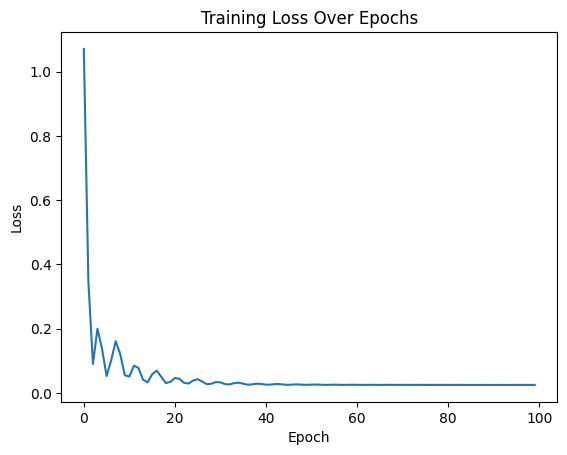

In [19]:
scrambled_states = scramble_state_vectors(np.array(encoded_data), seed)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
encoded_data = torch.tensor(encoded_data, dtype=torch.float32)

num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states.view(num_samples, -1))
    loss = criterion(outputs, encoded_data.view(num_samples, -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.62160105..1.0049261].


(100, 8, 8, 4)


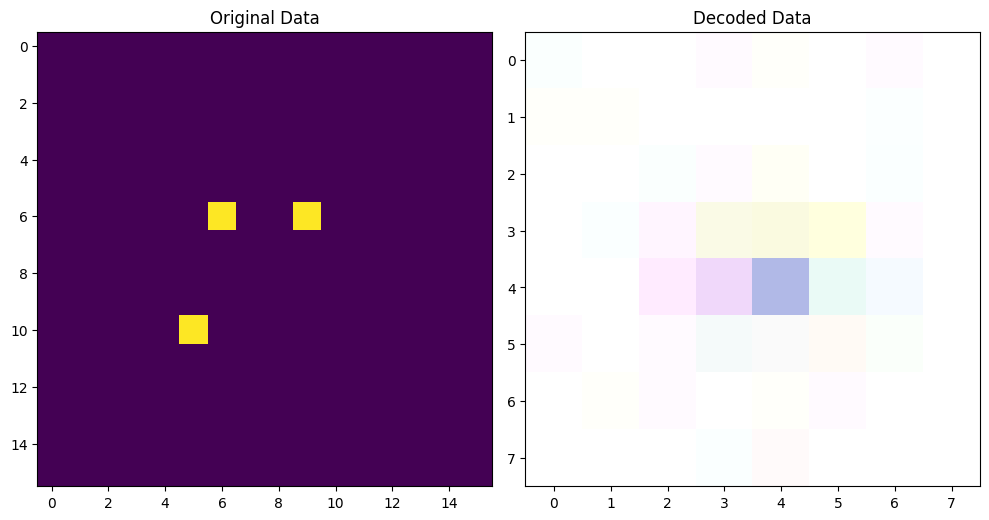

In [25]:
denoised_states = model(scrambled_states.view(num_samples, -1))
denoised_states = denoised_states.view(num_samples, 8, 8, 4).detach().numpy()
print(denoised_states.shape)


visualize_data(data_X, denoised_states, sample_index=1)


(100, 8, 8, 4)
(100000, 16, 16)
[[[ 0.01753831 -0.00241315 -0.00387383 ...  0.01869088 -0.00288069
   -0.00403261]
  [ 0.00160879 -0.00414586 -0.00346828 ... -0.00270343 -0.00353551
   -0.00302899]
  [-0.00159883 -0.0039643  -0.00319934 ... -0.00244439 -0.00255704
   -0.00205219]
  ...
  [-0.00239539 -0.00289249  0.01773083 ... -0.00222814 -0.00172734
   -0.00201273]
  [-0.00331593 -0.00112069 -0.00131381 ... -0.00082111 -0.00271058
   -0.00365865]
  [-0.00293446 -0.00255692 -0.00254035 ...  0.03692305 -0.00231135
    0.01854753]]

 [[ 0.01753831 -0.00241315 -0.00387383 ...  0.01869088 -0.00288069
   -0.00403261]
  [ 0.00160879 -0.00414586 -0.00346828 ... -0.00270343 -0.00353551
   -0.00302899]
  [-0.00159883 -0.0039643  -0.00319934 ... -0.00244439 -0.00255704
   -0.00205219]
  ...
  [-0.00239539 -0.00289249  0.01773083 ... -0.00222814 -0.00172734
   -0.00201273]
  [-0.00331593 -0.00112069 -0.00131381 ... -0.00082111 -0.00271058
   -0.00365865]
  [-0.00293446 -0.00255692 -0.00254035 ..

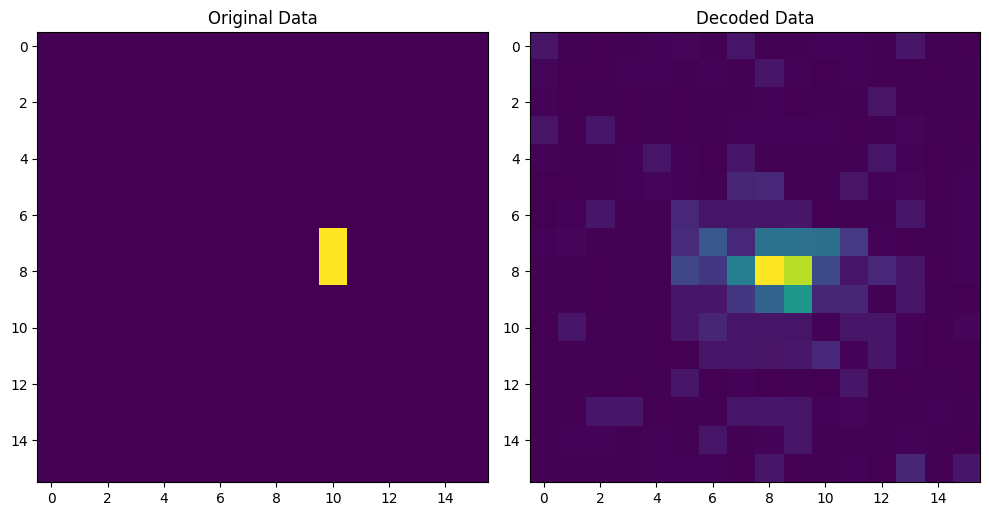

In [32]:
print(denoised_states.shape)
print(data_X.shape)

# Decode [num_samples, 8, 8, 4] into 1 channel [num_samples, 16, 16]
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_qubits = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_qubits):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

decoded_data = decode(denoised_states)
decoded_data = flip(decoded_data)
print(decoded_data)

visualize_data(data_X, decoded_data, sample_index=0)